# Imports and Global Functions/Variables

In [46]:
import numpy as np
from numpy.linalg import norm
import os
import tensorflow as tf
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate # type: ignore
from tensorflow.keras import backend as K #type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

GRID_SIZE = 6

# Sample-wise normalization
def normalize_matrix(matrix):
    return (matrix - np.mean(matrix)) / (np.std(matrix) + 1e-5)

def accuracy_within_threshold(y_true, y_pred, threshold=0.5):
    errors = np.linalg.norm(y_true - y_pred, axis=1)
    return np.mean(errors <= threshold)

# Load and Preprocess Training Data

In [47]:
dataset_dirs = [
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_0",
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_1"
]

X, y = [], []

# Toggle baseline shift augmentation
AUGMENT_WITH_BASELINE_SHIFT = True
MAX_SHIFT = 100  # adjust range if needed

# Apply synthetic baseline shift
def add_baseline_shift(matrix, max_shift=100):
    shift = np.random.uniform(-max_shift, max_shift)
    return matrix + shift

# Load and preprocess each sample
for dataset_dir in dataset_dirs:
    for fname in sorted(os.listdir(dataset_dir)):
        if fname.endswith(".npy"):
            matrix = np.load(os.path.join(dataset_dir, fname)).astype("float32") / 4095.0

            if AUGMENT_WITH_BASELINE_SHIFT:
                matrix = add_baseline_shift(matrix, MAX_SHIFT)

            matrix = normalize_matrix(matrix)
            X.append(matrix)

            # Extract label from filename: x_y_i.npy → (x, y)
            base = fname.split(".")[0]
            x, y_pos, _ = map(int, base.split("_"))
            y.append((x, y_pos))

X = np.array(X)  # shape: (N, GRID_SIZE, GRID_SIZE)
y = np.array(y)  # shape: (N, 2)

# Add positional channels
rows, cols = X.shape[1:3]
x_coords = np.tile(np.arange(cols), (rows, 1)) / (cols - 1)
y_coords = np.tile(np.arange(rows), (cols, 1)).T / (rows - 1)

x_channel = np.tile(x_coords, (len(X), 1, 1))
y_channel = np.tile(y_coords, (len(X), 1, 1))

X = np.stack([X, x_channel, y_channel], axis=-1)  # shape: (N, GRID_SIZE, GRID_SIZE, 3)

# Build and Train CNN Model

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define bounded MSE loss
def bounded_mse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

    lower_bound = 0.0
    upper_bound = tf.cast(GRID_SIZE - 1, tf.float32)

    under_penalty = tf.square(tf.clip_by_value(lower_bound - y_pred, 0.0, np.inf))
    over_penalty = tf.square(tf.clip_by_value(y_pred - upper_bound, 0.0, np.inf))
    penalty = tf.reduce_sum(under_penalty + over_penalty, axis=-1)

    return mse + 10.0 * penalty

# Build model
input_layer = Input(shape=(GRID_SIZE, GRID_SIZE, 3))
x = Conv2D(32, (4, 2), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='linear')(x)

model = Model(input_layer, output)
model.compile(optimizer="adam", loss=bounded_mse, metrics=["mae"])

# Split validation
X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Train model
history = model.fit(
    X_train_main, y_train_main,
    epochs=2000,
    batch_size=4,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MAE: {mae:.3f} (in coordinate units)")

Epoch 1/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4831 - mae: 1.4038 - val_loss: 0.8400 - val_mae: 0.7468
Epoch 2/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.7279 - mae: 0.6561 - val_loss: 0.6276 - val_mae: 0.6247
Epoch 3/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.6506 - mae: 0.6051 - val_loss: 0.6038 - val_mae: 0.5697
Epoch 4/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.5625 - mae: 0.5648 - val_loss: 0.7299 - val_mae: 0.5692
Epoch 5/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.6868 - mae: 0.6000 - val_loss: 0.6525 - val_mae: 0.5258
Epoch 6/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.5660 - mae: 0.5372 - val_loss: 0.5315 - val_mae: 0.5099
Epoch 7/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.5183 - mae: 0.5159 - val_loss: 0.6316 - val_mae: 0.5479
Epoch 8/2000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.5136 - mae: 0.5067 - val_loss: 0.5426 - val_mae: 0.5037
Epoch 9/2000
130/130 ━━━━━

# Evaluate Test/Validation Accuracy on Training Data

In [ ]:
# Predict and evaluate
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_within_threshold(y_test, y_test_pred, threshold=0.5)
print(f"Test accuracy within 0.5 units: {test_accuracy:.2%}")

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_within_threshold(y_val, y_val_pred, threshold=0.5)
print(f"Validation accuracy within 0.5 units: {val_accuracy:.2%}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Test accuracy within 0.5 units: 83.33%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Validation accuracy within 0.5 units: 84.48%


# Plot Training Dataset CNN Results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 


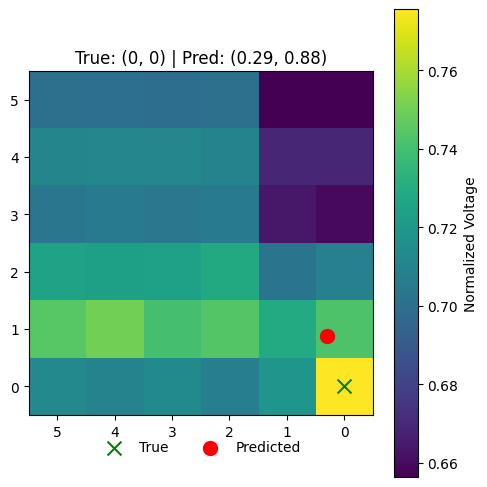

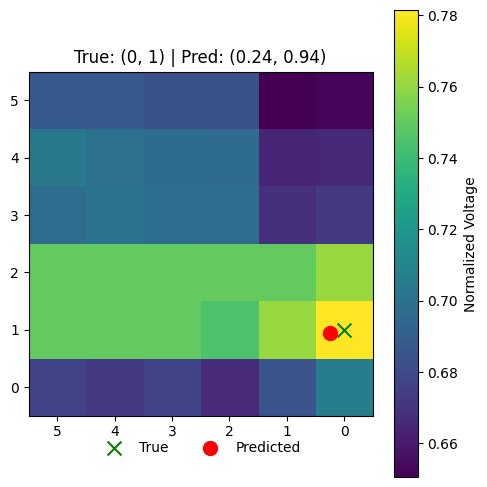

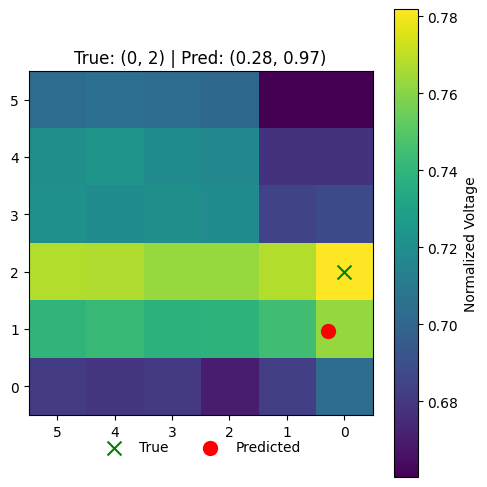

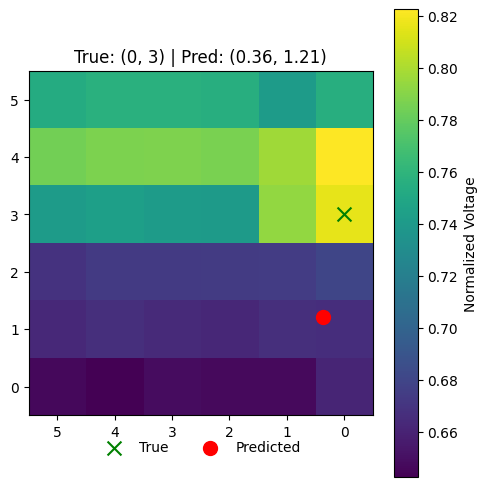

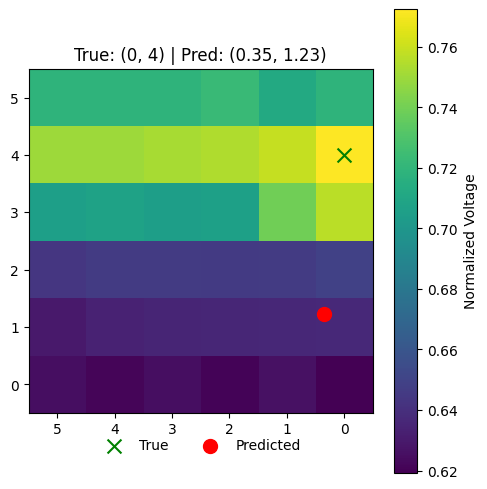

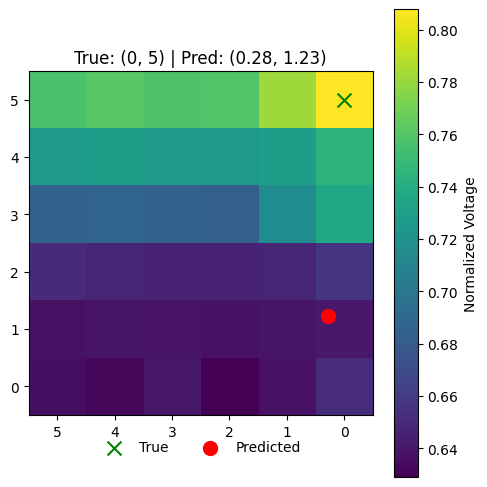

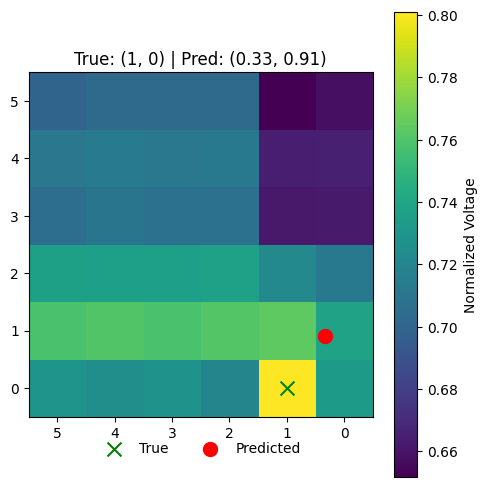

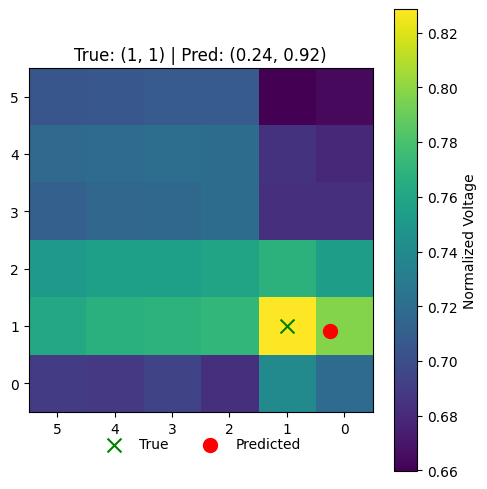

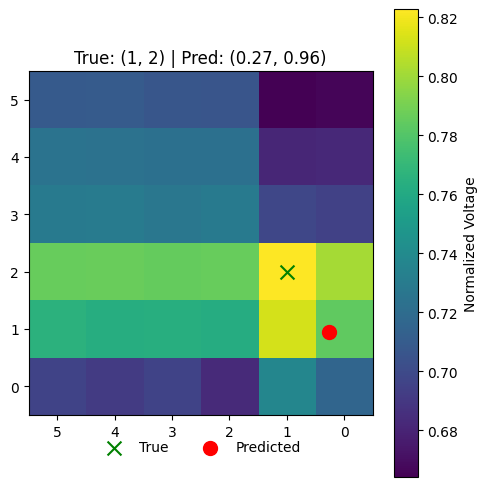

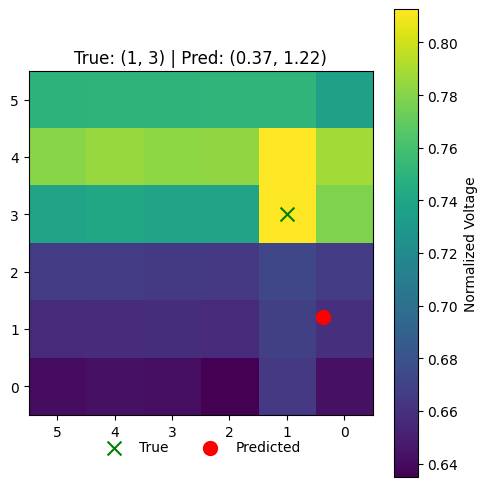

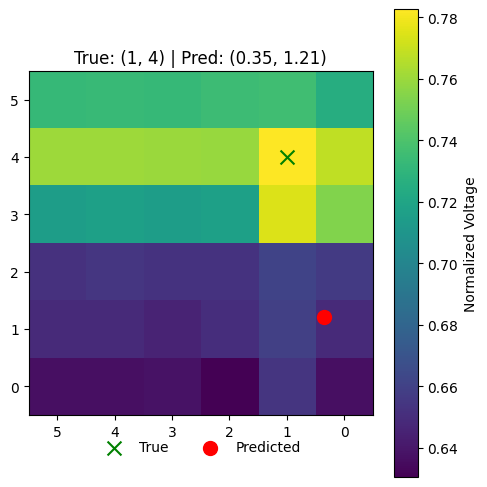

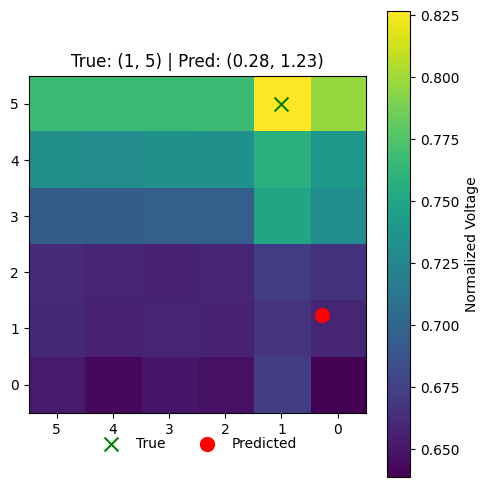

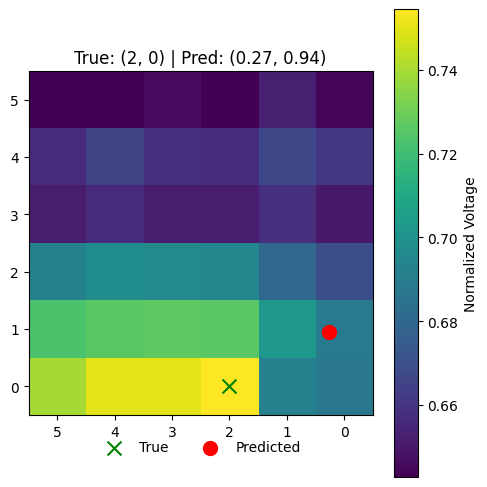

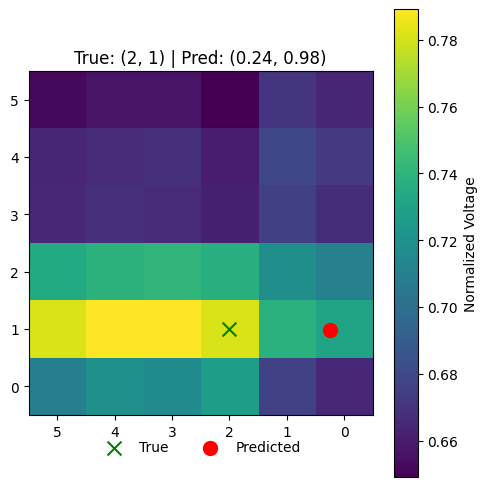

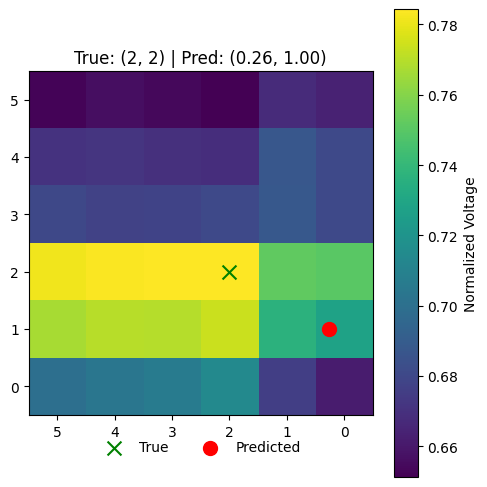

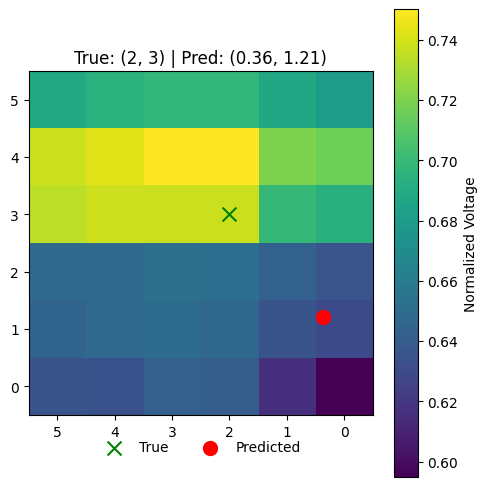

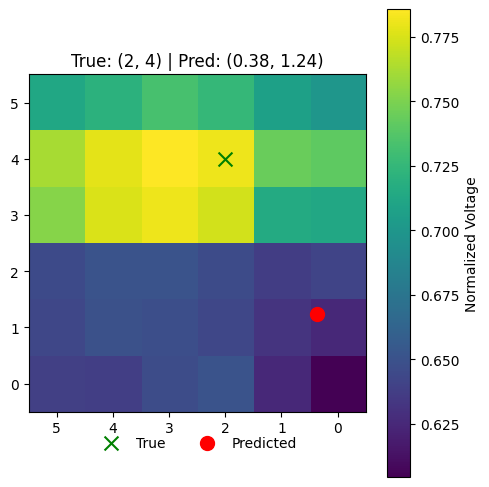

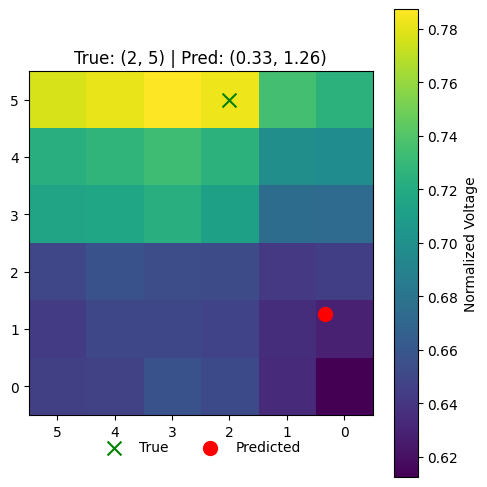

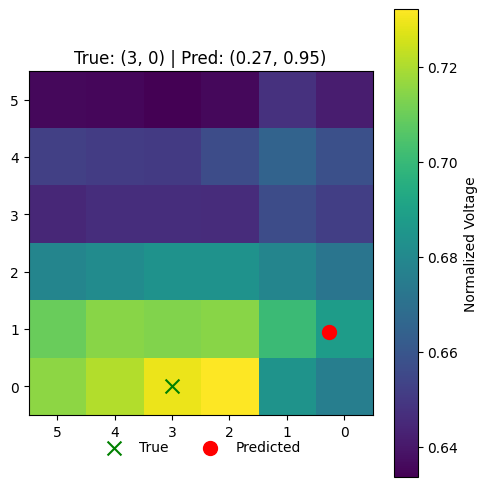

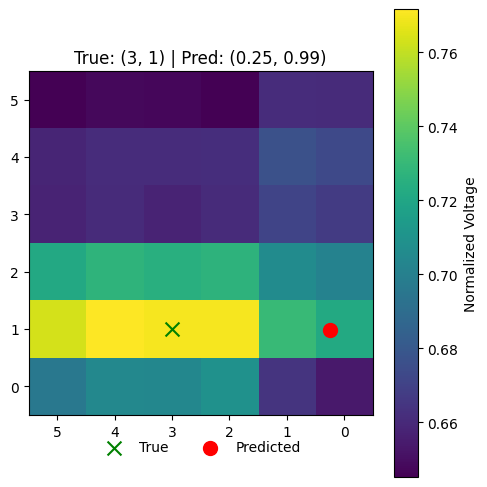

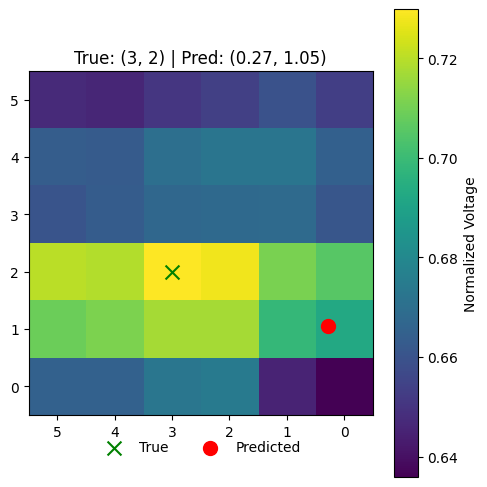

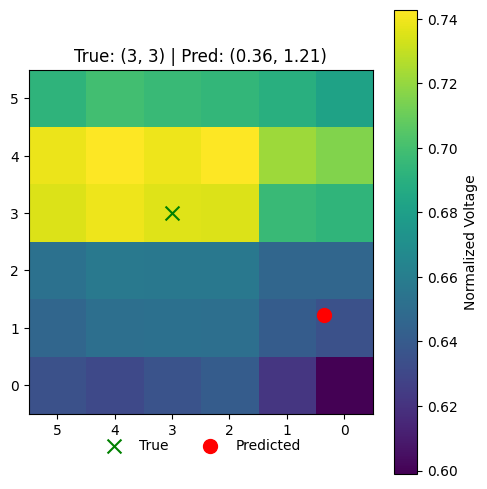

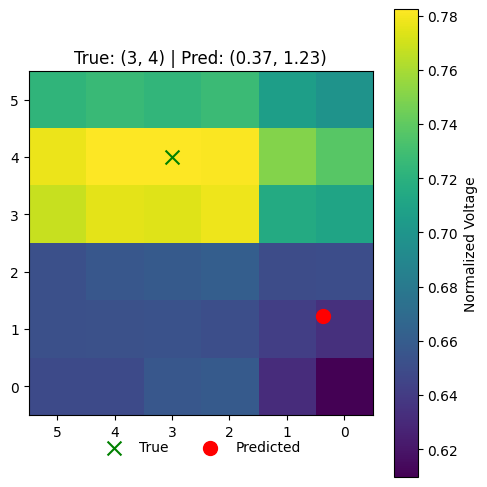

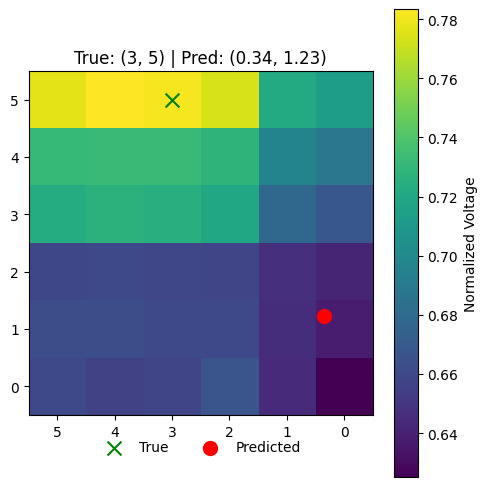

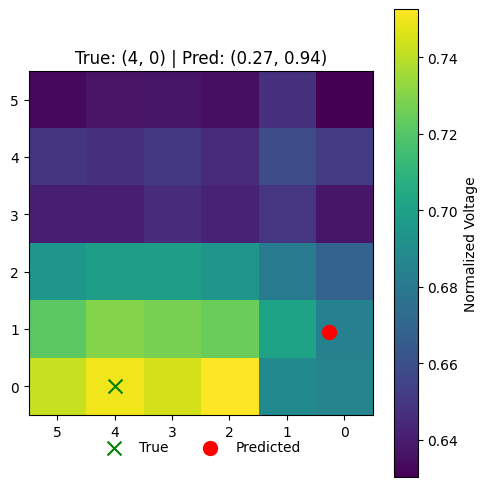

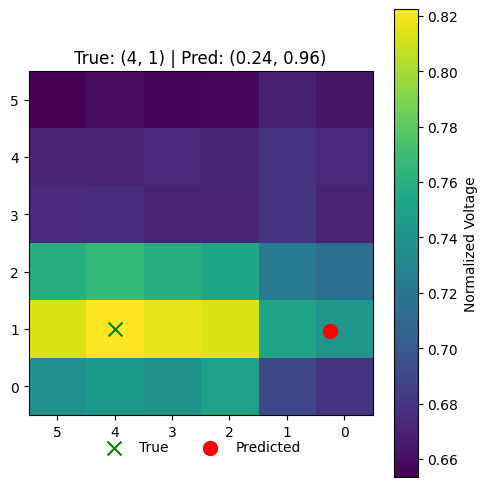

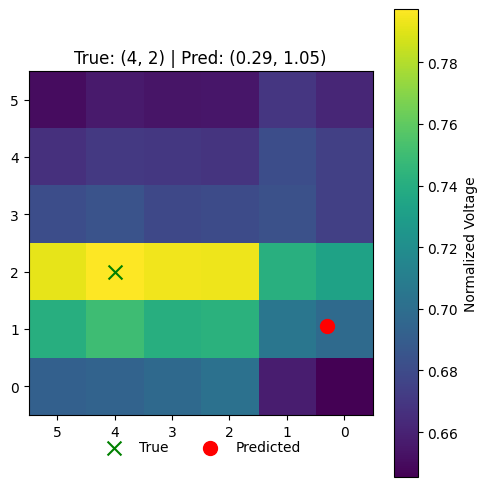

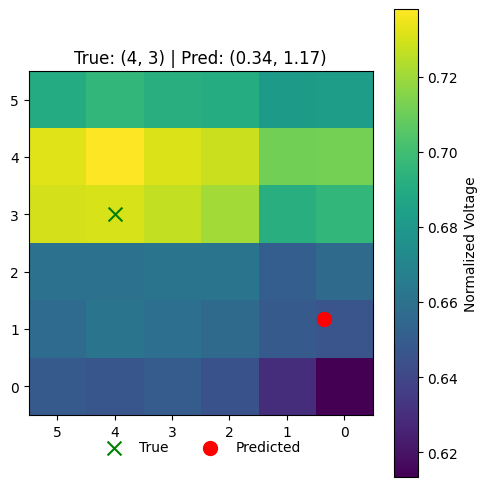

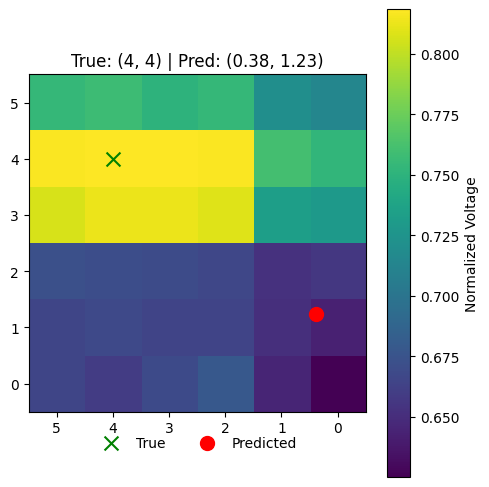

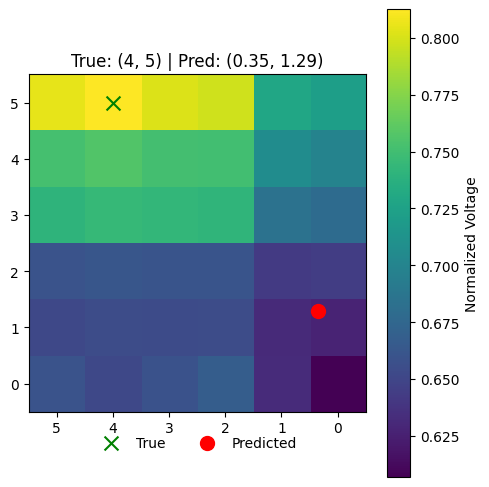

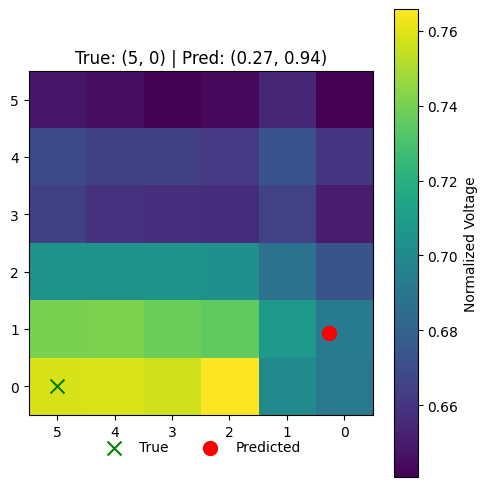

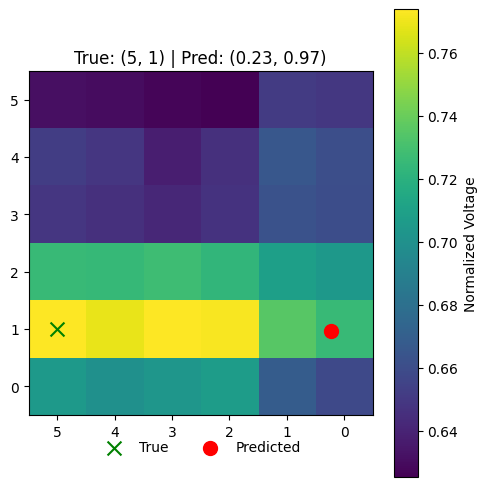

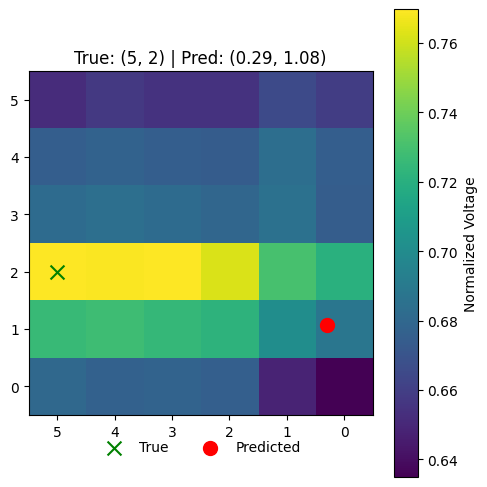

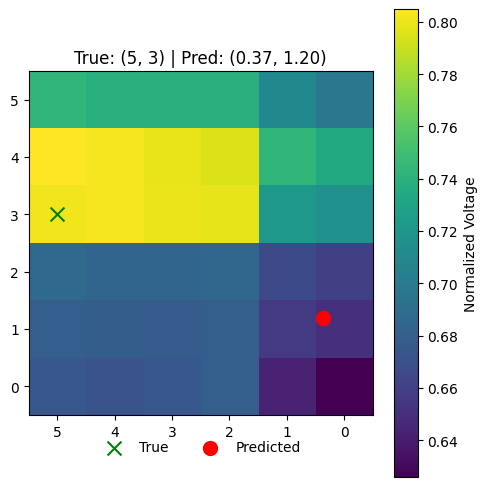

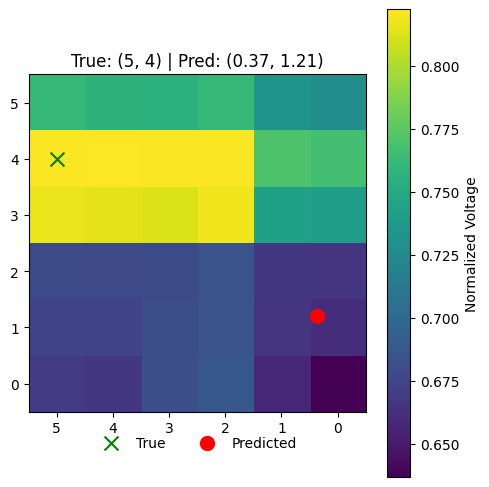

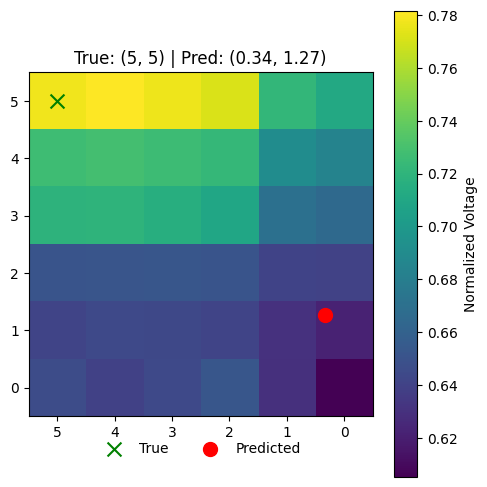

In [54]:
# Build a lookup of one example per (x, y) point
unique_samples = {}
for i in range(len(y_test)):
    key = tuple(y_test[i])
    if key not in unique_samples:
        unique_samples[key] = i
    if len(unique_samples) == 36:
        break

all_preds = model.predict(X_test)

# Plot one sample per point
for (true_x, true_y), i in sorted(unique_samples.items()):
    matrix = X_test[i][..., 0]
    pred_x, pred_y = all_preds[i]

    corrected_matrix = np.flipud(matrix)
    marker_x = 5 - true_x
    marker_y = true_y
    pred_marker_x = 5 - pred_x
    pred_marker_y = pred_y

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(corrected_matrix, cmap="viridis", origin="lower")
    plt.colorbar(im, ax=ax, label="Normalized Voltage")

    ax.scatter(marker_x, marker_y, color='green', marker='x', s=100, label='True')
    ax.scatter(pred_marker_x, pred_marker_y, color='red', marker='o', s=100, label='Predicted')

    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(list(reversed(range(6))))
    ax.set_yticks(np.arange(6))
    ax.set_yticklabels(range(6))
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(-0.5, 5.5)

    ax.set_title(f"True: ({true_x}, {true_y}) | Pred: ({pred_x:.2f}, {pred_y:.2f})")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# Load and Preprocess Testing Data

In [48]:
# Load testing_set_0
external_test_dir = "/Users/alexahitov/Desktop/arduino/Pressure Pad/testing_set_0"
X_ext, y_ext = [], []

# Same normalization function as in training
def normalize_matrix(matrix):
    return (matrix - np.mean(matrix)) / (np.std(matrix) + 1e-5)

for fname in sorted(os.listdir(external_test_dir)):
    if fname.endswith(".npy"):
        matrix = np.load(os.path.join(external_test_dir, fname)).astype("float32") / 4095.0
        matrix = normalize_matrix(matrix)

        X_ext.append(matrix)

        # Parse label from filename
        x, y_pos, _ = map(int, fname[:-4].split("_"))
        y_ext.append((x, y_pos))

X_ext = np.array(X_ext)
y_ext = np.array(y_ext)

# Add positional encoding channels
x_coords = np.tile(np.arange(GRID_SIZE), (GRID_SIZE, 1)) / (GRID_SIZE - 1)
y_coords = np.tile(np.arange(GRID_SIZE), (GRID_SIZE, 1)).T / (GRID_SIZE - 1)

x_channel = np.tile(x_coords, (len(X_ext), 1, 1))
y_channel = np.tile(y_coords, (len(X_ext), 1, 1))

X_ext = np.stack([X_ext, x_channel, y_channel], axis=-1)

# Perdict and Evaluate Testing Data

In [49]:
# Predict on external test set
y_ext_pred = model.predict(X_ext)

# Mean Absolute Error (MAE)
ext_mae = np.mean(np.abs(y_ext_pred - y_ext))
print(f"External test MAE: {ext_mae:.3f} (in coordinate units)")

# Accuracy within 0.5 units
ext_accuracy = accuracy_within_threshold(y_ext, y_ext_pred, threshold=0.5)
print(f"External test accuracy within 0.5 units: {ext_accuracy:.2%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
External test MAE: 0.511 (in coordinate units)
External test accuracy within 0.5 units: 41.67%


# Plot Testing Dataset CNN Results

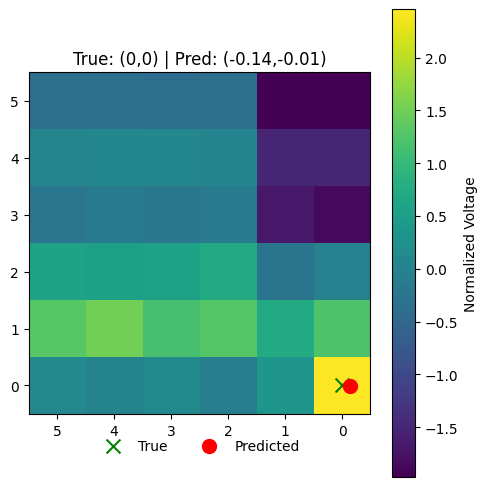

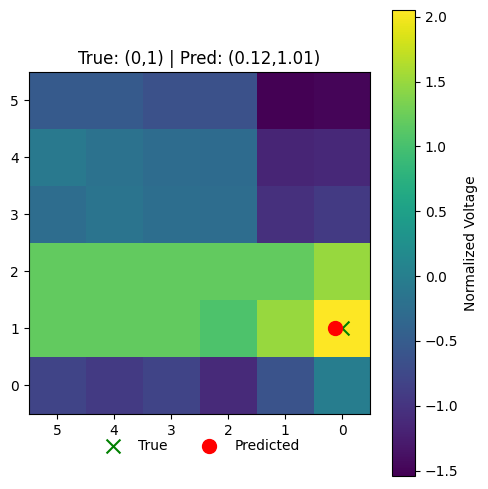

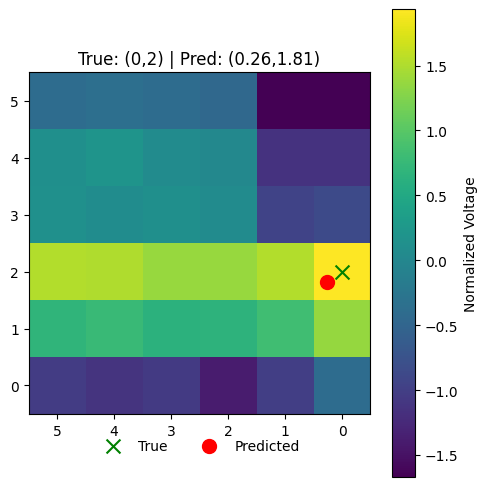

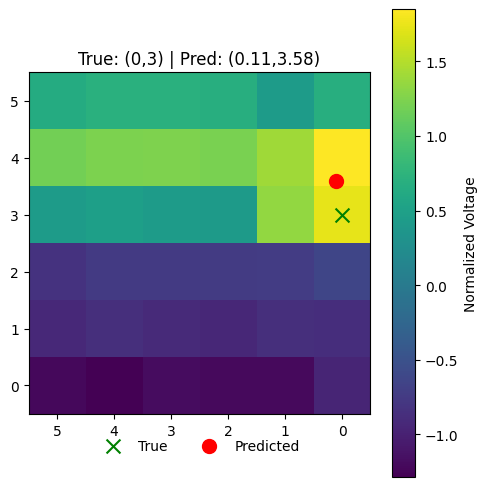

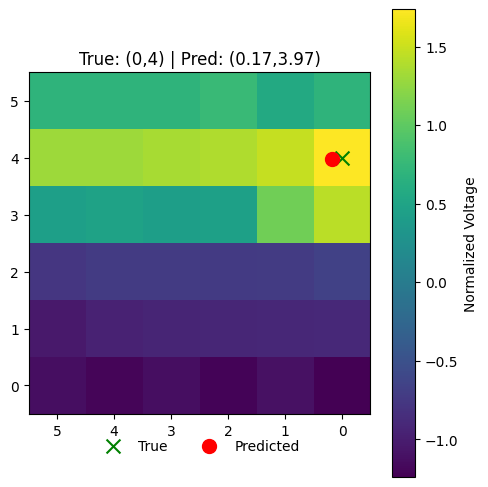

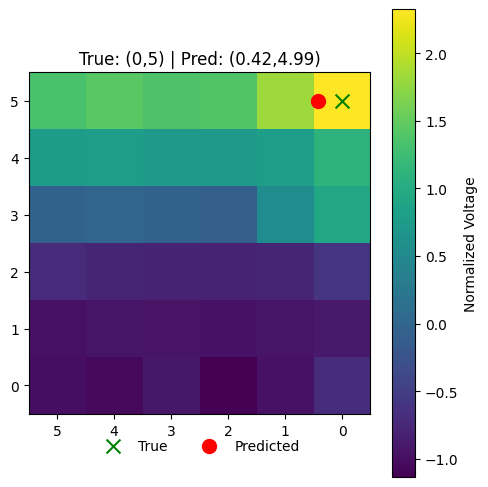

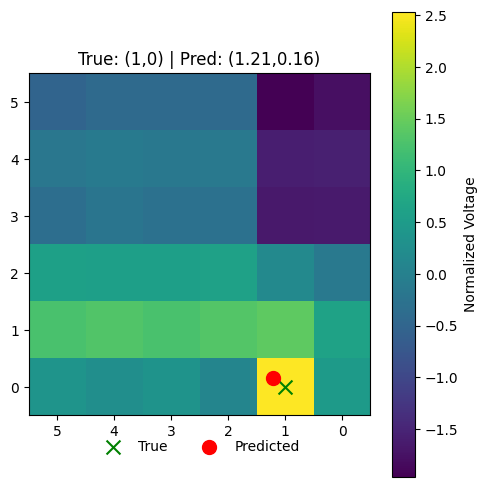

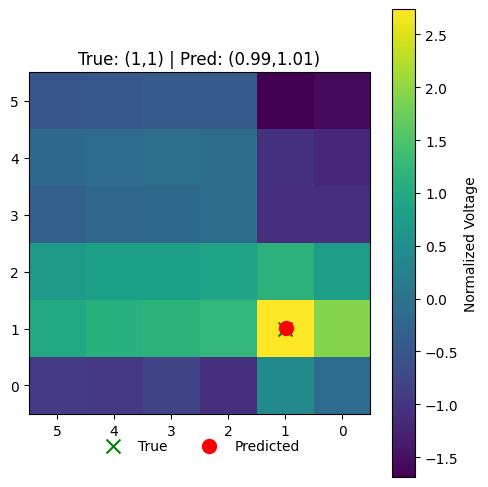

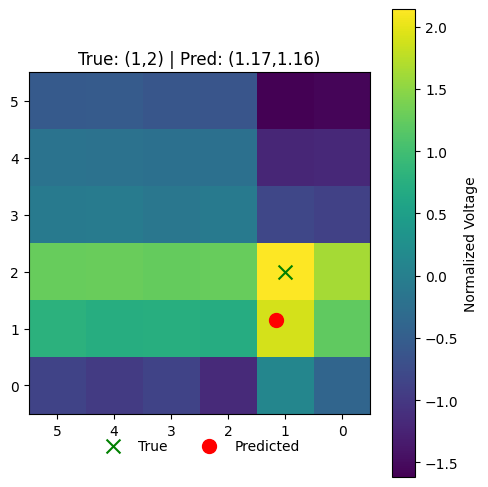

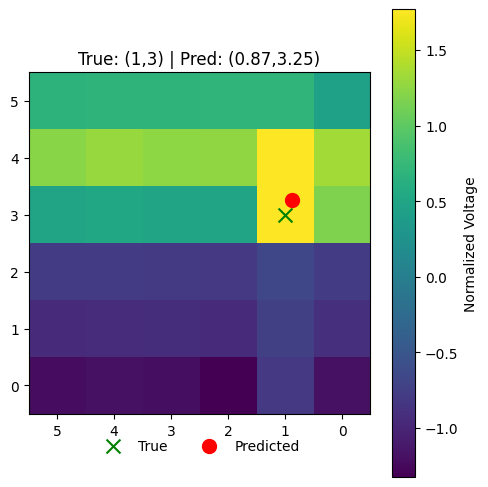

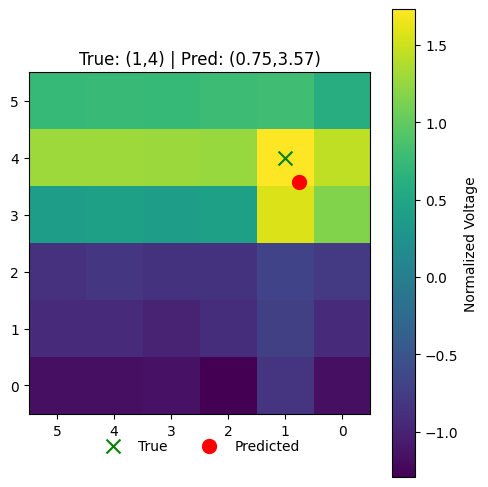

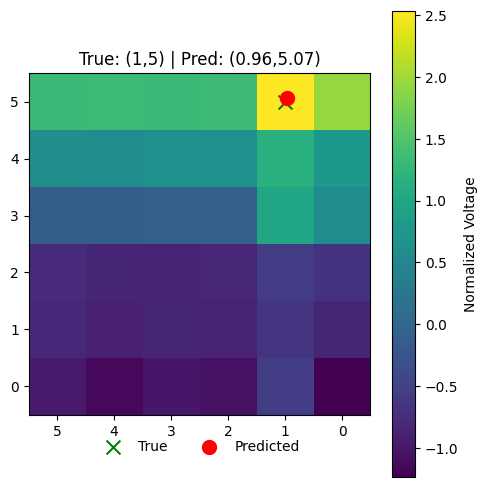

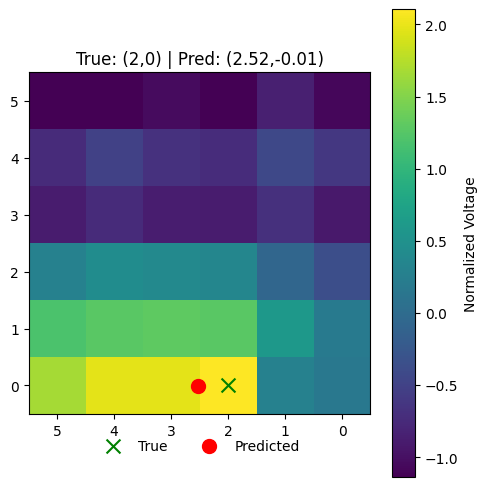

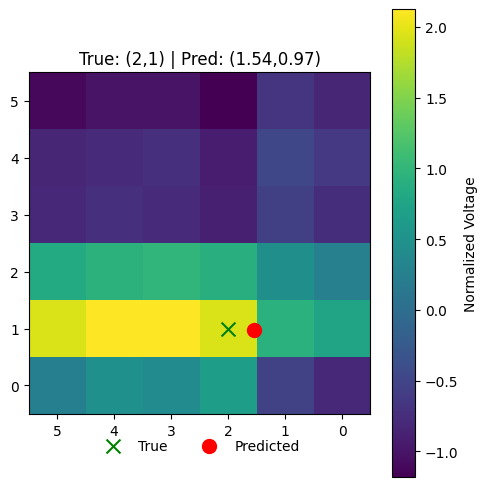

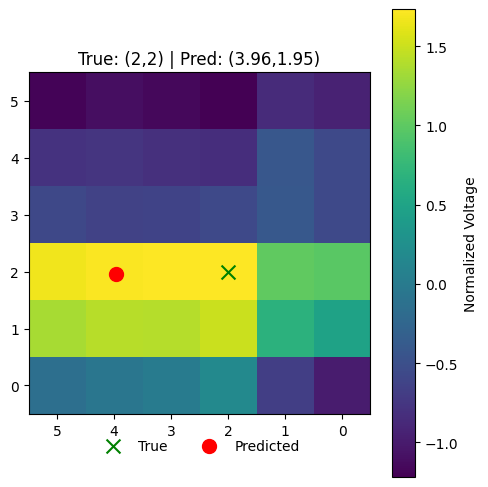

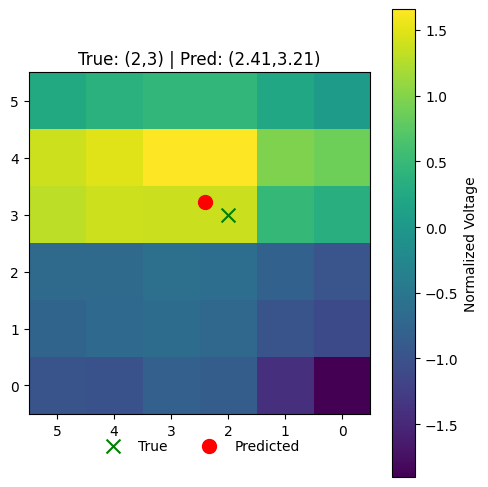

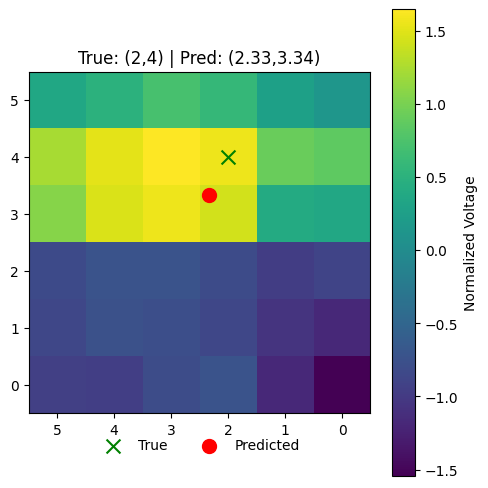

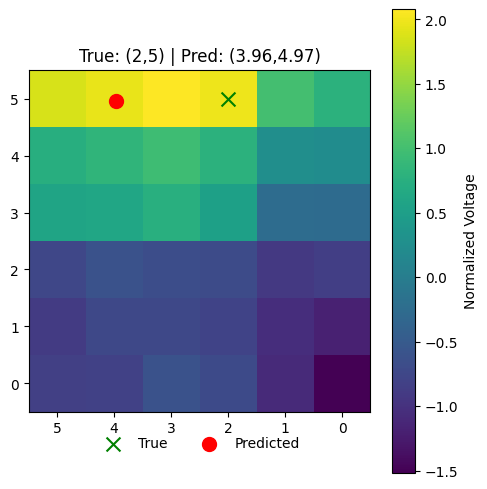

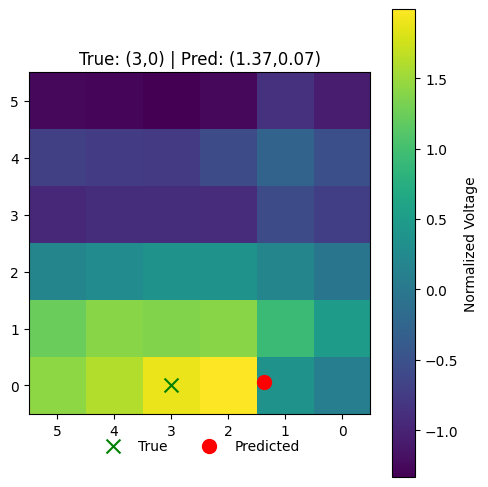

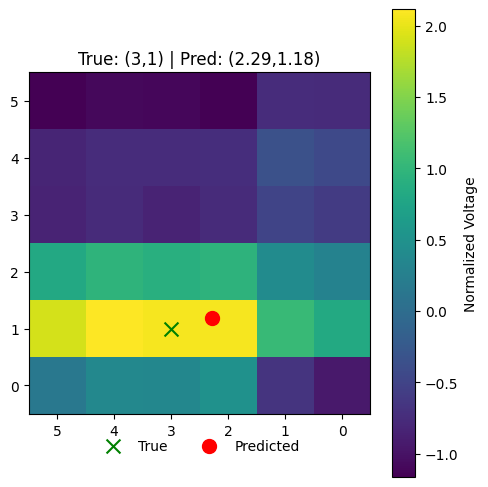

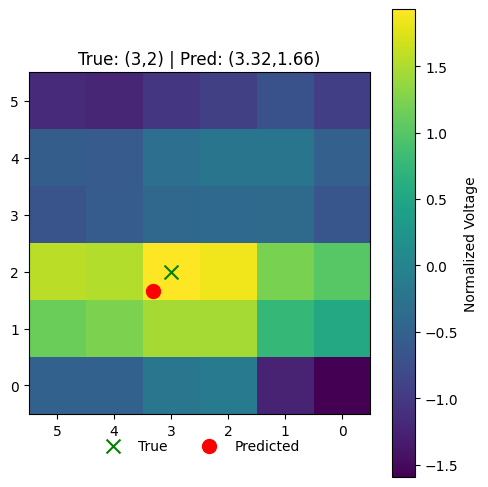

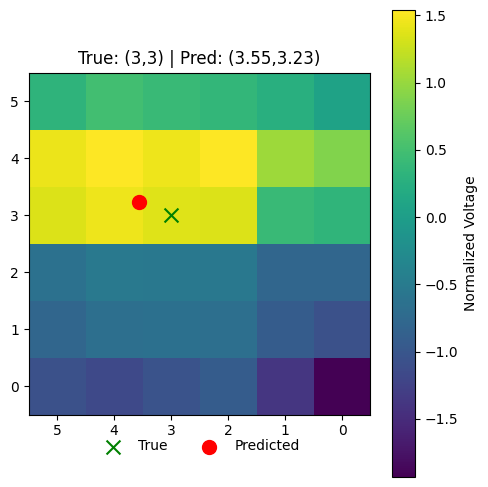

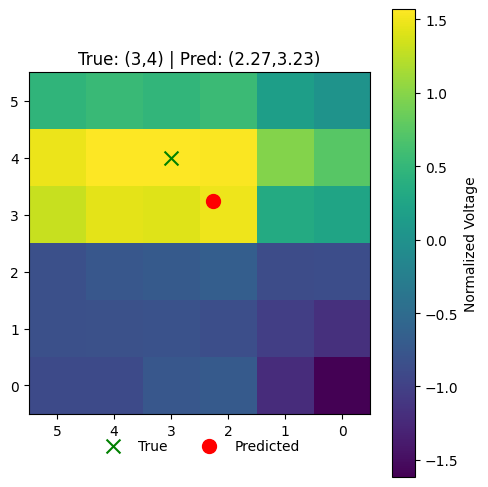

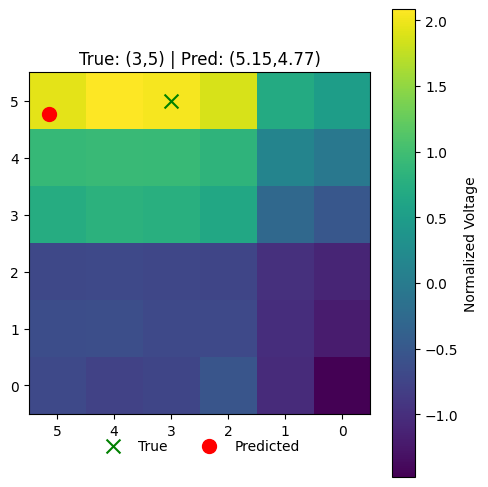

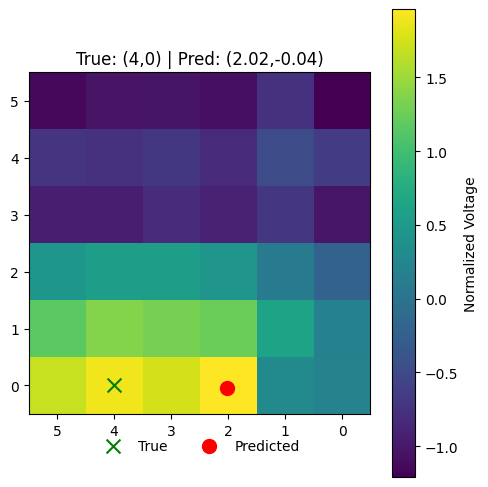

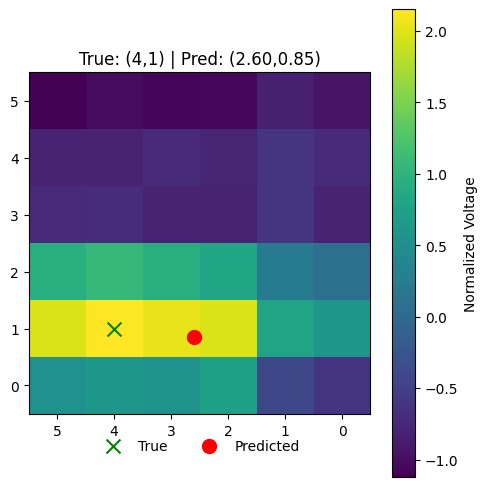

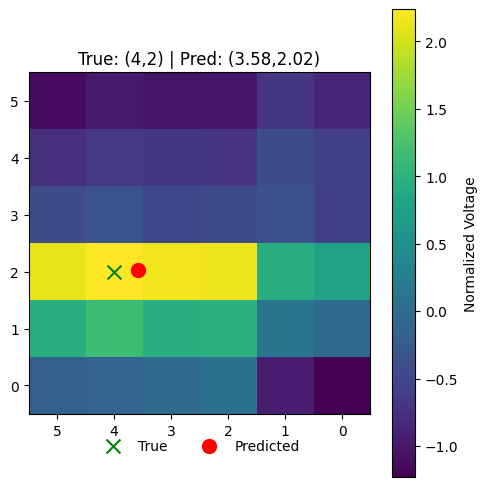

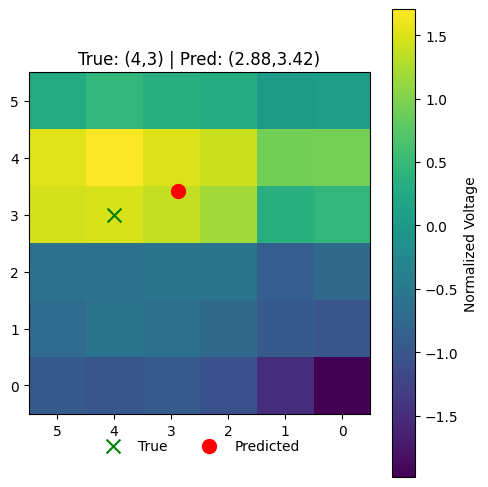

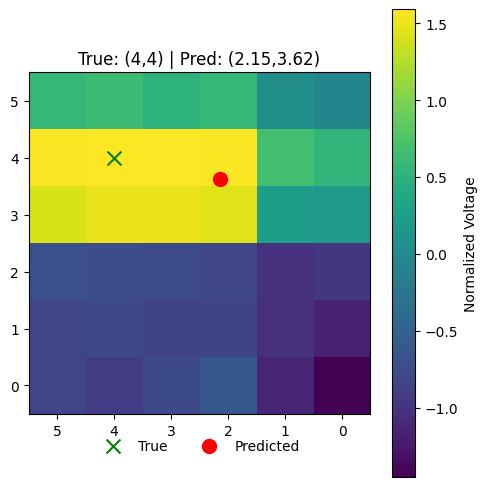

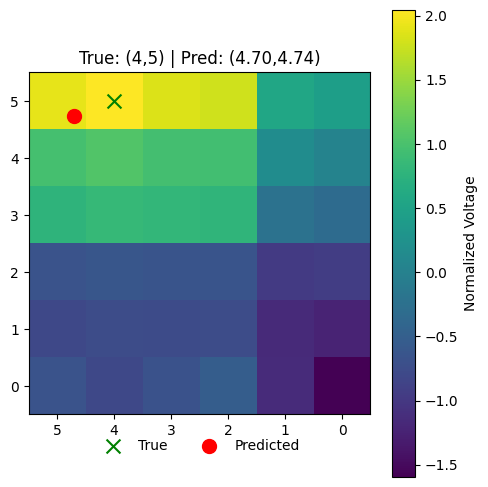

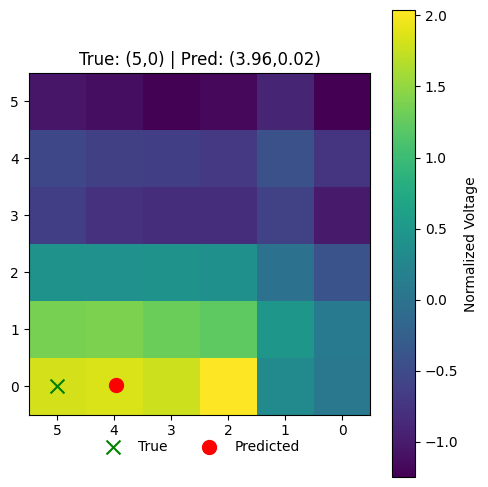

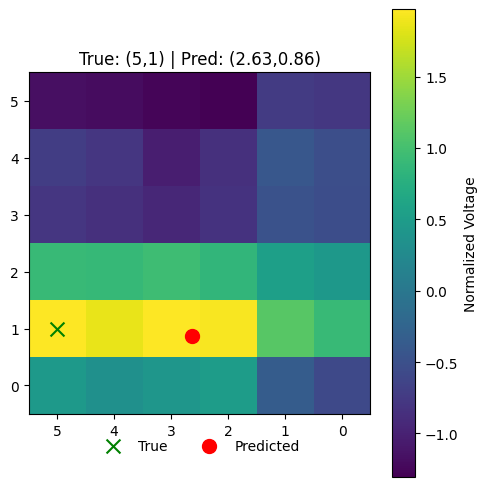

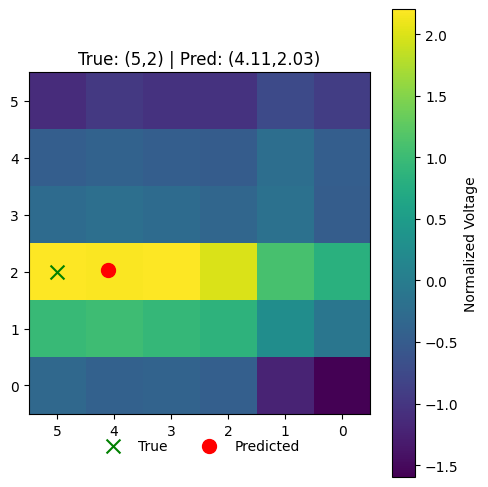

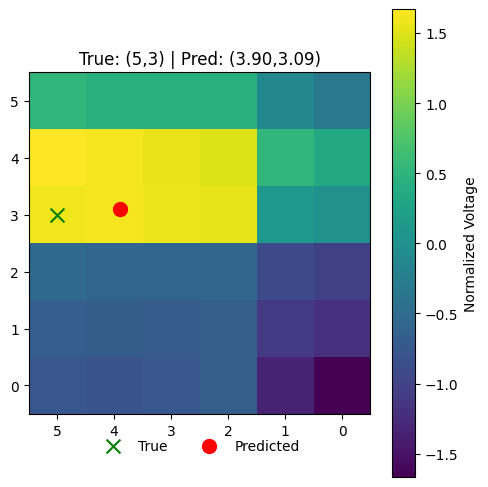

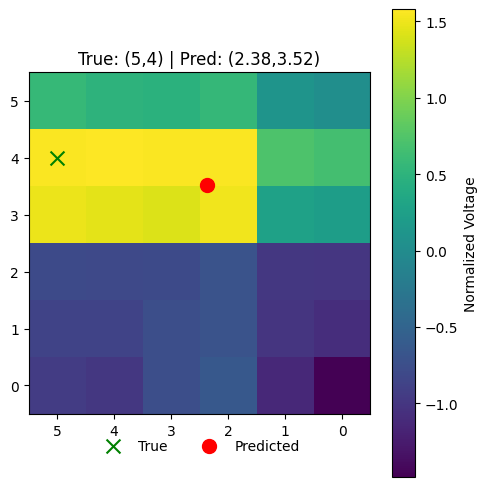

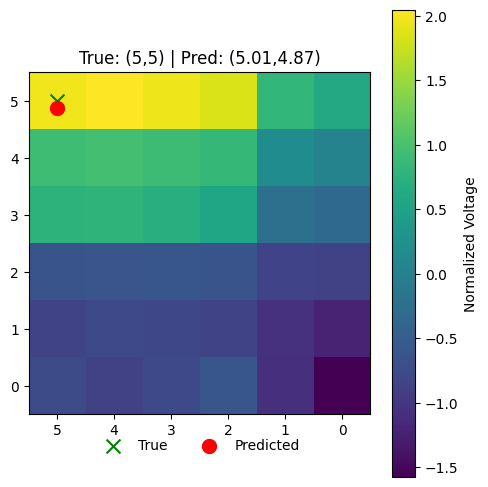

In [50]:
for i in range(len(X_ext)):
    matrix = X_ext[i][..., 0]
    true_x, true_y = y_ext[i]
    pred_x, pred_y = y_ext_pred[i]

    corrected_matrix = np.flipud(matrix)
    marker_x = 5 - int(true_x)
    marker_y = int(true_y)
    pred_marker_x = 5 - pred_x
    pred_marker_y = pred_y

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(corrected_matrix, cmap="viridis", origin="lower")
    plt.colorbar(im, ax=ax, label="Normalized Voltage")
    ax.scatter(marker_x, marker_y, color='green', marker='x', s=100, label='True')
    ax.scatter(pred_marker_x, pred_marker_y, color='red', marker='o', s=100, label='Predicted')

    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(list(reversed(range(6))))
    ax.set_yticks(np.arange(6))
    ax.set_yticklabels(range(6))
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(-0.5, 5.5)
    ax.set_title(f"True: ({true_x},{true_y}) | Pred: ({pred_x:.2f},{pred_y:.2f})")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()


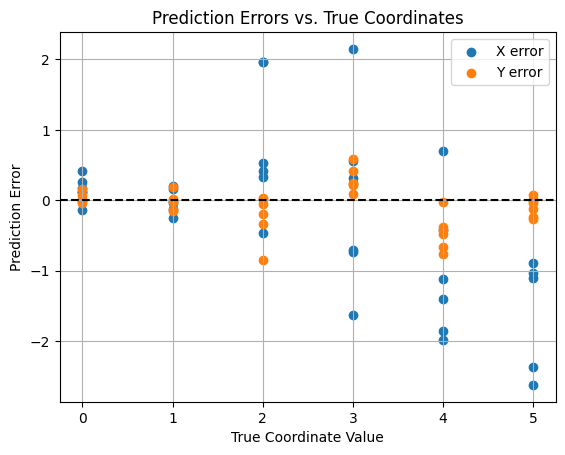

In [55]:
errors = y_ext_pred - y_ext
plt.scatter(y_ext[:, 0], errors[:, 0], label='X error')
plt.scatter(y_ext[:, 1], errors[:, 1], label='Y error')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.title("Prediction Errors vs. True Coordinates")
plt.xlabel("True Coordinate Value")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()


In [56]:
x_mae = np.mean(np.abs(y_ext_pred[:, 0] - y_ext[:, 0]))
y_mae = np.mean(np.abs(y_ext_pred[:, 1] - y_ext[:, 1]))
print(f"External MAE — X: {x_mae:.3f}, Y: {y_mae:.3f}")

External MAE — X: 0.813, Y: 0.210


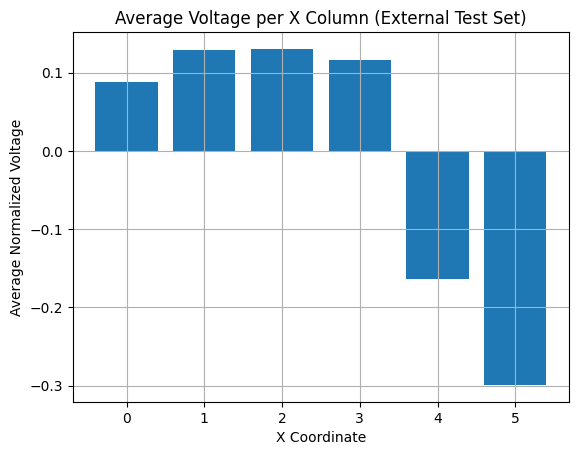

In [57]:
avg_voltages_by_x = np.mean(X_ext[..., 0], axis=(0, 1))  # mean across all samples and y

import matplotlib.pyplot as plt
plt.bar(range(GRID_SIZE), avg_voltages_by_x)
plt.title("Average Voltage per X Column (External Test Set)")
plt.xlabel("X Coordinate")
plt.ylabel("Average Normalized Voltage")
plt.grid(True)
plt.show()

# Compare Training and Testing Datasets

In [51]:
def load_dataset(folders):
    # Accept a single folder as a string, or multiple as a list/tuple
    if isinstance(folders, str):
        folders = [folders]
    X, y = [], []
    for folder in folders:
        for fname in sorted(os.listdir(folder)):
            if fname.endswith(".npy"):
                matrix = np.load(os.path.join(folder, fname)).astype("float32") / 4095.0
                label = tuple(map(int, fname.split(".")[0].split("_")[:2]))
                X.append(matrix)
                y.append(label)
    return np.array(X), np.array(y)

def add_position_channels(X):
    rows, cols = X.shape[1:3]
    x_coords = np.tile(np.arange(cols), (rows, 1)) / (cols - 1)
    y_coords = np.tile(np.arange(rows), (cols, 1)).T / (rows - 1)
    x_channel = np.tile(x_coords, (len(X), 1, 1))
    y_channel = np.tile(y_coords, (len(X), 1, 1))
    return np.stack([X, x_channel, y_channel], axis=-1)

# Load original training data
X_train_raw, y_train = load_dataset(dataset_dirs)
X_train = add_position_channels(X_train_raw)

# Load new test dataset
X_test_raw, y_test = load_dataset("testing_set_0")
X_test = add_position_channels(X_test_raw)

# Get one sample per point from each dataset
def select_unique_samples(X, y):
    sample_dict = {}
    for i in range(len(y)):
        key = tuple(y[i])
        if key not in sample_dict:
            sample_dict[key] = i
        if len(sample_dict) == 36:
            break
    return sample_dict

train_dict = select_unique_samples(X_train_raw, y_train)
test_dict  = select_unique_samples(X_test_raw, y_test)

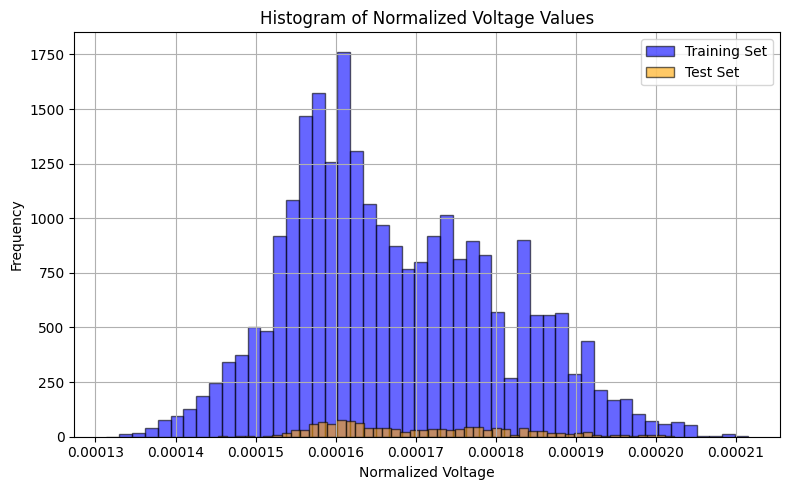

In [52]:
# Flatten all voltage values from both sets
train_values = X_train_raw.reshape(-1) / 4095.0
test_values = X_test_raw.reshape(-1) / 4095.0

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(train_values, bins=50, alpha=0.6, label="Training Set", color='blue', edgecolor='black')
plt.hist(test_values, bins=50, alpha=0.6, label="Test Set", color='orange', edgecolor='black')

# Add labels and legend
plt.title("Histogram of Normalized Voltage Values")
plt.xlabel("Normalized Voltage")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

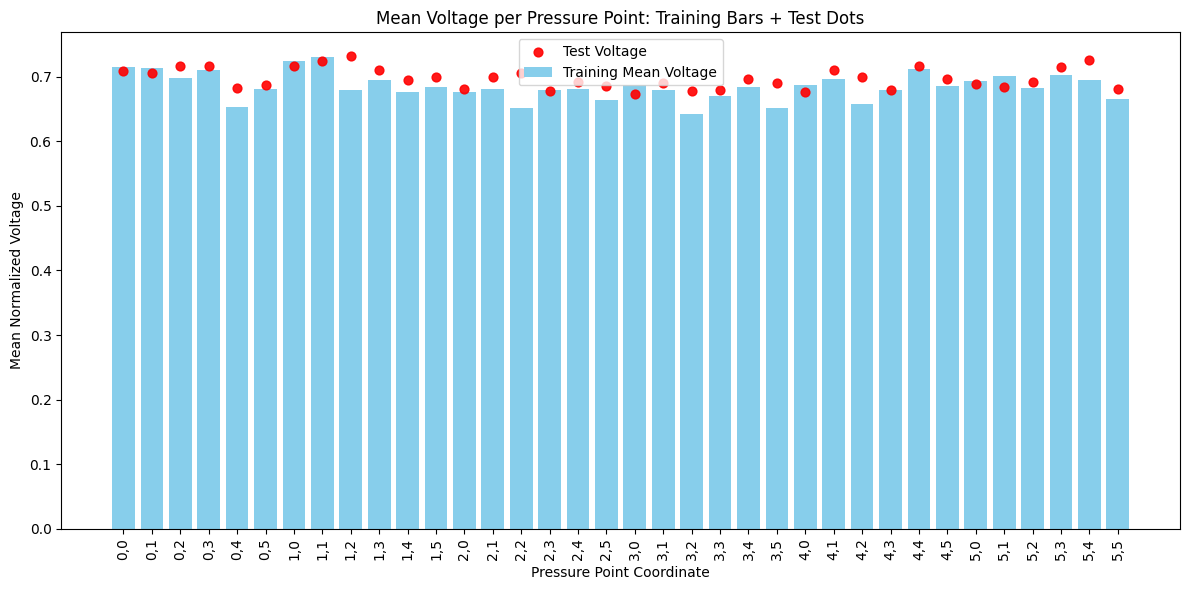

In [53]:
test_dir = "/Users/alexahitov/Desktop/arduino/Pressure Pad/testing_set_0"

# Parse training data
train_data = {}
for train_dir in dataset_dirs:
    for fname in os.listdir(train_dir):
        if fname.endswith(".npy"):
            label = tuple(map(int, fname[:-4].split("_")[:2]))
            matrix = np.load(os.path.join(train_dir, fname)).astype("float32") / 4095.0
            if label not in train_data:
                train_data[label] = []
            train_data[label].append(np.mean(matrix))

# Compute mean per pressure point for training
train_means = {pt: np.mean(vals) for pt, vals in train_data.items()}

# Parse testing data
test_points = []
test_values = []
for fname in os.listdir(test_dir):
    if fname.endswith(".npy"):
        label = tuple(map(int, fname[:-4].split("_")[:2]))
        matrix = np.load(os.path.join(test_dir, fname)).astype("float32") / 4095.0
        test_points.append(label)
        test_values.append(np.mean(matrix))

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for training means
train_labels = sorted(train_means.keys())
label_strs = [f"{x},{y}" for x, y in train_labels]
train_y = [train_means[pt] for pt in train_labels]
x_pos = np.arange(len(train_labels))
bars = ax.bar(x_pos, train_y, color="skyblue", label="Training Mean Voltage")

# Overlay test values as red dots
label_to_index = {f"{x},{y}": i for i, (x, y) in enumerate(train_labels)}
plotted = set()
for (x, y), val in zip(test_points, test_values):
    label = f"{x},{y}"
    if label in label_to_index:
        show_label = "Test Voltage" if label not in plotted else None
        ax.scatter(label_to_index[label], val, color="red", s=40, alpha=0.9, label=show_label)
        plotted.add(label)

# Set labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels(label_strs, rotation=90)
ax.set_ylabel("Mean Normalized Voltage")
ax.set_xlabel("Pressure Point Coordinate")
ax.set_title("Mean Voltage per Pressure Point: Training Bars + Test Dots")

# Clean legend (avoid duplicates)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()

In [76]:
# Plot each grid point side by side
pdf = PdfPages("side_by_side_predictions.pdf")

for (x, y) in sorted(train_dict.keys()):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

    for j, (title, data_dict, X_raw, X_proc) in enumerate([
        ("Training", train_dict, X_train_raw, X_train),
        ("Test", test_dict, X_test_raw, X_test)
    ]):
        if (x, y) not in data_dict:
            axs[j].axis('off')
            continue

        idx = data_dict[(x, y)]
        matrix = np.flipud(X_raw[idx])  # Flip Y-axis
        pred_x, pred_y = model.predict(X_proc[idx:idx+1])[0]

        # Flip X-axis coordinates
        marker_x = 5 - x
        marker_y = y
        pred_marker_x = 5 - pred_x
        pred_marker_y = pred_y

        im = axs[j].imshow(matrix, cmap="viridis", origin="lower")
        axs[j].scatter(marker_x, marker_y, color='green', marker='x', s=100, label='True')
        axs[j].scatter(pred_marker_x, pred_marker_y, color='red', marker='o', s=100, label='Predicted')
        axs[j].set_title(f"{title} | True: ({x},{y})\nPred: ({pred_x:.2f},{pred_y:.2f})")
        axs[j].set_xticks(np.arange(6))
        axs[j].set_xticklabels(list(reversed(range(6))))
        axs[j].set_yticks(np.arange(6))
        axs[j].set_yticklabels(range(6))
        axs[j].set_xlim(-0.5, 5.5)
        axs[j].set_ylim(-0.5, 5.5)

    fig.colorbar(im, ax=axs.ravel().tolist(), label="Normalized Voltage")
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━